In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
import lsst.geom as lsstGeom
from lsst.afw import cameraGeom
import lsst.afw.math as afwMath
import lsst.daf.butler as dB
import yaml
from math import isnan

The next functions, used to plot the heat maps in the focal plane, were copied from  https://github.com/lsst-camera-dh/jh-ccs-utils/blob/master/python/focal_plane_plotting.py

In [2]:
def get_amp_patches(det, amps=None):
    """
    Return a list of Rectangle patches in focalplane coordinates
    corresponding to the amplifier segments in a detector object.
    Parameters
    ----------
    det: `lsst.afw.cameraGeom.detector.detector.Detector`
        Detector object.
    amps: container-type object [None]
        Python container that can be queried like `'C01 in amps'`
        to see if a particular channel is included for plotting.
        If None, then use all channels in det.
    Returns
    -------
    list of matplotlib.patches.Rectangle objects
    """
    transform = det.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    bbox = list(det)[0].getBBox()
    dy, dx = bbox.getHeight(), bbox.getWidth()
    patches = []
    for amp in det:
        if amps is not None and amp.getName() not in amps:
            continue
        j, i = tuple(int(_) for _ in amp.getName()[1:])
        y, x = j*dy, i*dx
        x0, y0 = transform.applyForward(lsstGeom.Point2D(x, y))
        x1, y1 = transform.applyForward(lsstGeom.Point2D(x + dx, y + dy))
        patches.append(Rectangle((x0, y0), x1 - x0, y1 - y0))
    return patches


def plot_amp_boundaries(ax, camera=None, edgecolor='blue', facecolor='white'):
    """
    Plot the amplifier boundaries for all of the detectors in a camera.
    Parameters
    ----------
    ax: `matplotlib.Axes`
        Axes object used to render the patch collection containing
        the amplifier boundary Rectangles.
    camera: `lsst.afw.cameraGeom.camera.camera.Camera` [None]
        Camera object containing the detector info. If None, use
        `lsst.obs.lsst.imsim.ImsimMapper().camera`
    edgecolor: str or tuple of RGBA values ["blue"]
        Color used to draw outline of amplifiers.
    facecolor: str or tuple of RGBA values ["white"]
        Color used to render the Rectangle corresponding to the
        amplifier region.
    Returns
    -------
    None
    """
    if camera is None:
        camera = ImsimMapper().camera
    patches = []
    for det in camera:
        patches.extend(get_amp_patches(det))
    pc = PatchCollection(patches, edgecolor=edgecolor, facecolor=facecolor)
    ax.add_collection(pc)


def plot_det(ax, det, amp_values, cm=plt.cm.hot, z_range=None, use_log10=False):
    """
    Plot the amplifiers in a detector, rendering each amplier region with
    a color corresponding to its assigned value.
    Parameters
    ----------
    ax: `matplotlib.Axes`
        Axes object used to render the patch collection containing
        the amplifier boundary Rectangles.
    det: `lsst.afw.cameraGeom.detector.detector.Detector`
        Detector object.
    amp_values: dict of floats
        Dictionary of amplifier values to render, keyed by channel ID,
        e.g., 'C00', 'C01', etc.
    cm: `matplotlib.colors.Colormap`
        Colormap used to render amplifier values.
    z_range: 2-tuple of floats [None]
        Minimum and maximum values into which to map the unit interval
        for the color map.  Values are mapped using
        max(0, min(1, (amp_value - z_range[0])/(z_range[1] - z_range[0])))
        If None, then use
        z_range = (min(amp_values.values()), max(amp_values.values()))
    use_log10: bool [False]
        If True, then use log10(amp_value) for positive amp_value.  For
        non-positive amp_value, don't render the amp color.
    Returns
    -------
    None
    """
    if z_range is None:
        zvals = amp_values.values()
        z_range = min(zvals), max(zvals)
    def mapped_value(amp_values):
        return max(0, min(1., ((amp_values - z_range[0])
                               /(z_range[1] - z_range[0]))))
    my_facecolors = []
    for amp in det:
        if amp.getName() not in amp_values:
            continue
        if use_log10:
            if amp_values[amp.getName()] <= 0:
                my_facecolors.append(None)
            else:
                my_facecolors.append(
                    cm(mapped_value(np.log10(amp_values[amp.getName()]))))
        else:
            my_facecolors.append(cm(mapped_value(amp_values[amp.getName()])))

    my_patches = get_amp_patches(det, amp_values)
    facecolors, patches = [], []
    for facecolor, patch in zip(my_facecolors, my_patches):
        if facecolor is not None:
            facecolors.append(facecolor)
            patches.append(patch)
    assert len(facecolors) == len(patches)
    pc = PatchCollection(patches, facecolors=facecolors)
    ax.add_collection(pc)


def get_median_nsigma_range(amp_data, nsigma=4, use_log10=False):
    """
    Use a clipped stdev to compute the range of amp_data appropriate
    for plotting as a full focal plane mosaic or as a histogram of
    per-amp values.  The returned range will be
    (median - nsigma*stdev_clip, median + nsigma*stdev_clip).
    Parameters
    ----------
    amp_data: dict of dict of floats
        Dictionary of dictionary of amplifier values to render,
        keyed by detector name, e.g., 'R01_S00' and then by channel ID,
        e.g., 'C00'.
    nsigma: float [4]
        Number of sigma to use for computing the plotting range.
    use_log10: bool [False]
        If True, then use the log10 of the amp_data values, excluding
        non-positive values.
    Returns
    -------
    (float, float)
    """
    amp_values = []
    for _ in amp_data.values():
        amp_values.extend(_.values())
    amp_values = np.array(amp_values, dtype=np.float64)
    if use_log10:
        amp_values = np.array([np.log10(_) for _ in amp_values if _ > 0])
    stats = afwMath.makeStatistics(amp_values,
                                   afwMath.MEDIAN | afwMath.STDEVCLIP)
    median = stats.getValue(afwMath.MEDIAN)
    stdev = stats.getValue(afwMath.STDEVCLIP)
    return (median - nsigma*stdev, median + nsigma*stdev)


def plot_focal_plane(ax, amp_data, camera=None, cm=plt.cm.hot,
                     x_range=(-325, 325), y_range=(-325, 325),
                     z_range=None, use_log10=False, scale_factor='1',
                     title='', nsigma=4):
    """
    Make a "heat map" plot of the focalplane using per-amplifier values.
    Parameters
    ----------
    ax: `matplotlib.Axes`
        Axes object used to render the patch collection containing
        the amplifier boundary Rectangles.
    amp_data: dict of dict of floats
        Dictionary of dictionary of amplifier values to render,
        keyed by detector name, e.g., 'R01_S00' and then by channel ID,
        e.g., 'C00'.
    camera: `lsst.afw.cameraGeom.camera.camera.Camera` [None]
        Camera object containing the detector info. If None, use
        `lsst.obs.lsst.imsim.ImsimMapper().camera`
    cm: `matplotlib.colors.Colormap`
        Colormap used to render amplifier values.
    x_range: tuple [(-325, 325)]
        Focalplane plotting region in x-direction in units of mm.
    y_range: tuple [(-325, 325)]
        Focalplane plotting region in y-direction in units of mm.
    z_range: 2-tuple of floats [None]
        Minimum and maximum values into which to map the unit interval
        for the color map.  Values are mapped using
        max(0, min(1, (amp_value - z_range[0])/(z_range[1] - z_range[0])))
        If None, then use
        z_range = get_median_nsigma_range(amp_data, nsigma=nsigma,
                                          use_log10=use_log10)
    use_log10: bool [False]
        If True, then use log10(amp_value) for positive amp_value.  For
        non-positive amp_value, don't render the amp color.
    scale_factor: str ['1']
        Scale factor to apply to the colorbar mapping.  This value
        will be cast as a float when applied to the tick label values.  It
        is passed as a string so that formatting in the colorbar tick
        labels can be controlled directly by the client code.
        This is not used if use_log10 == True.
    title: str ['']
        Title to apply to the plot.
    nsigma: float [4]
        Number of sigma to apply to clipped stdev for an "autoscaled"
        z_range, i.e., [median - nsigm*stdev_clip, median + nsigm*stdev_clip].
    Returns
    -------
    None
    """
    if camera is None:
        camera = ImsimMapper().camera
    plot_amp_boundaries(ax, camera=camera)
    if z_range is None:
        z_range_values = []
        for _ in amp_data.values():
            z_range_values.extend(_.values())
        if use_log10:
            z_range_values = [np.log10(_) for _ in z_range_values if _ > 0]
        z_range = min(z_range_values), max(z_range_values)
    elif z_range == 'clipped_autoscale':
        z_range = get_median_nsigma_range(amp_data, nsigma=nsigma,
                                          use_log10=use_log10)
    for det_name, amp_values in amp_data.items():
        plot_det(ax, camera[det_name], amp_values, cm=cm, z_range=z_range,
                 use_log10=use_log10)
        max_amp_value = max(amp_values.values())
    plt.xlim(*x_range)
    plt.ylim(*y_range)
    plt.xlabel('y (mm)', fontsize = 18)
    plt.ylabel('x (mm)', fontsize = 18)
    norm = plt.Normalize(vmin=z_range[0], vmax=z_range[1])
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])
    colorbar = plt.colorbar(sm)
    colorbar.ax.tick_params(labelsize=14)
    if use_log10:
        ticks = sorted(list(set([int(_) for _ in
                                 np.log10(np.logspace(0, z_range[1]))])))
        ticklabels = [10**_ for _ in ticks]
        colorbar.set_ticks(ticks)
        colorbar.set_ticklabels(ticklabels, fontsize=14)
    elif scale_factor != '1':
        ticks = colorbar.get_ticks()
        colorbar.set_ticks(ticks)
        ticklabels = [_/float(scale_factor) for _ in ticks]
        ticklabels[-1] = '{} x {}'.format(ticklabels[-1], scale_factor)
        colorbar.set_ticklabels(ticklabels, fontsize=14)
    plt.title(title, fontsize = 18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    return colorbar

def hist_amp_data(amp_data, x_label, bins=50, hist_range=None, color=None,
                  label=None, use_log10=False, yscale='log',
                  scale_factor='1'):
    """Histogram focal plane results from per amp data.
    amp_data: dict of dict of floats
        Dictionary of dictionary of amplifier values to render,
        keyed by detector name, e.g., 'R01_S00' and then by channel ID,
        e.g., 'C00'.
    x_label: str
        Label of x-axis. Typically, this is the results column name.
    bins: int [50]
        Number of histogram bins.
    hist_range: (float, float) [None]
        Histogram min and max values.  If None, then used plt.hist default.
    color: str [None]
        Histogram color.  If None, then used plt.hist default.
    label: str [None]
        Histogram label.
    use_log10: bool [False]
        If True, then use log10(amp_value) for positive amp_value.  For
        non-positive amp_value, don't render the amp color.
    yscale: str ['log']
        Argument to pass to plt.yscale(...).  The options are 'linear', 'log'.
    """
    amp_values = []
    for _ in amp_data.values():
        amp_values.extend(_.values())
    if use_log10:
        amp_values = [np.log10(_) for _ in amp_values if _ > 0]
    plt.hist(amp_values, bins=bins, range=hist_range, histtype='step',
             color=color, label=label)
    plt.xlabel(x_label)
    plt.ylabel('entries / bin')
    plt.yscale(yscale)
    ax = plt.axes()
    if use_log10:
        ticks = sorted(list(set([int(_) for _ in
                                 np.log10(np.logspace(0, max(amp_values)))])))
        ticklabels = [10**_ for _ in ticks]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
    elif scale_factor != '1':
        ticks = [_ for _ in ax.get_xticks()
                 if (_ >= hist_range[0] and _ <= hist_range[1])]
        ax.set_xticks(ticks)
        ticklabels = ['{:.1f}'.format(_/float(scale_factor)) for _ in ticks]
        ticklabels[-1] += f'\nx {scale_factor}'
        ax.set_xticklabels(ticklabels)

In [3]:
genCollection = "u/lgiraldo/bps_ALLCCD_20220701"
butler = dB.Butler("/repo/main/", collections=genCollection)

In [4]:
camera = butler.get("camera", instrument="LSSTCam")

In [5]:
with open('./Data_files/PTC_gain_dict.yaml', 'r') as file:
    gain_values = yaml.safe_load(file)
    
with open('./Data_files/PTC_noise_dict.yaml', 'r') as file:
    noise_values = yaml.safe_load(file)
    
with open('./Data_files/PTC_a00_dict.yaml', 'r') as file:
    a00_values = yaml.safe_load(file)
    
with open('./Data_files/PTC_turnoff_dict.yaml', 'r') as file:
    turnoff_values = yaml.safe_load(file)
    
with open('./Data_files/Correlation_coefficient_LowFluxRegime_2022AUG05.yaml', 'r') as file:
    corr_coef = yaml.safe_load(file)
    #clean_corr_coef = {k: corr_coef[k] for k in corr_coef if not isnan(corr_coef[k])}  ##Cleaning nan values
    
with open('./Data_files/Slope_LowFluxRegime_2022AUG05.yaml', 'r') as file:
    slope = yaml.safe_load(file)
    #clean_slope = {k: slope[k] for k in slope if not isnan(slope[k])}  ##Cleaning nan values
    
with open('./Data_files/Offset_LowFluxRegime_2022AUG05.yaml', 'r') as file:
    offset = yaml.safe_load(file)
    #clean_offset = {k: offset[k][] for k in offset for j in ofsset[k] if not isnan(offset[k])}  ##Cleaning nan values

In [6]:
clean_offset = {k:{j:  offset[k][j] for j in offset[k] if type(offset[k][j]) is not str} for k in offset}
clean_slope = {k:{j:  slope[k][j] for j in slope[k] if type(slope[k][j]) is not str} for k in slope}
clean_corr_coef = {k:{j:  corr_coef[k][j] for j in corr_coef[k] if type(corr_coef[k][j]) is not str} for k in corr_coef}

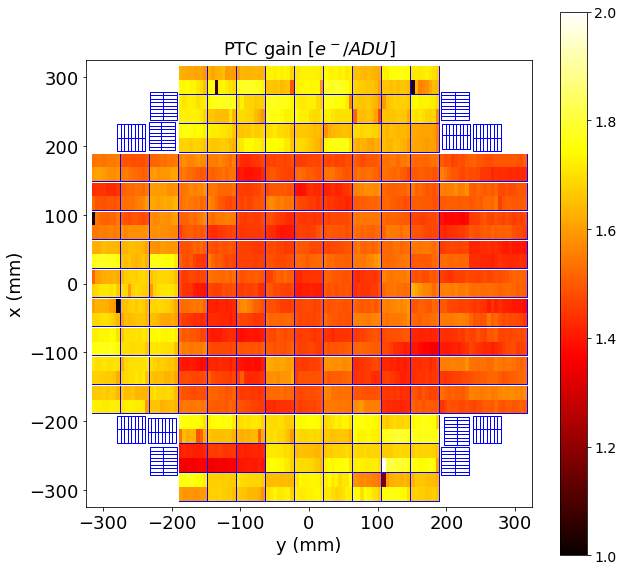

In [12]:
fig, axes = plt.subplots(figsize=(10,10))
axes.set_aspect('equal')
z = get_median_nsigma_range(gain_values, nsigma=3, use_log10=False)
plot_focal_plane(axes, gain_values, camera=camera, z_range=(1,2), title='PTC gain [$e^-/ADU$]');
fig.savefig('./FocalPlane_plots/Focal_plane_gain.png', dpi=500, bbox_inches='tight')

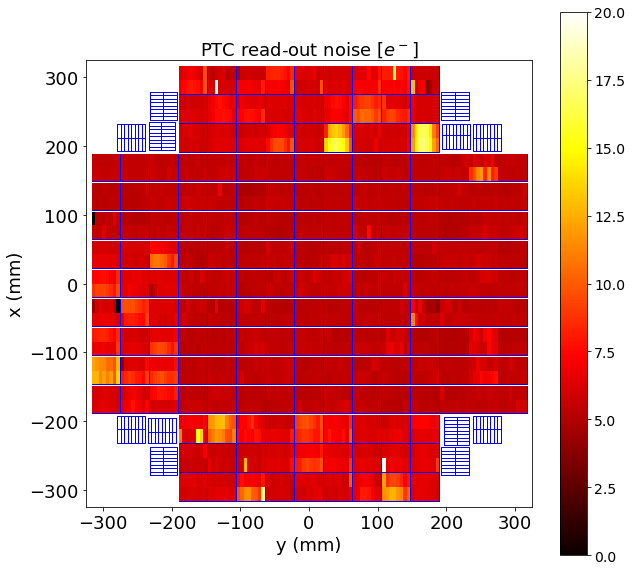

In [13]:
fig, axes = plt.subplots(figsize=(10,10))
axes.set_aspect('equal')
z1 = get_median_nsigma_range(noise_values, nsigma=3, use_log10=False)
plot_focal_plane(axes, noise_values, camera=camera, z_range=(0,20), title='PTC read-out noise [$e^-$]');
fig.savefig('./FocalPlane_plots/Focal_plane_noise.png', dpi=500, bbox_inches='tight')

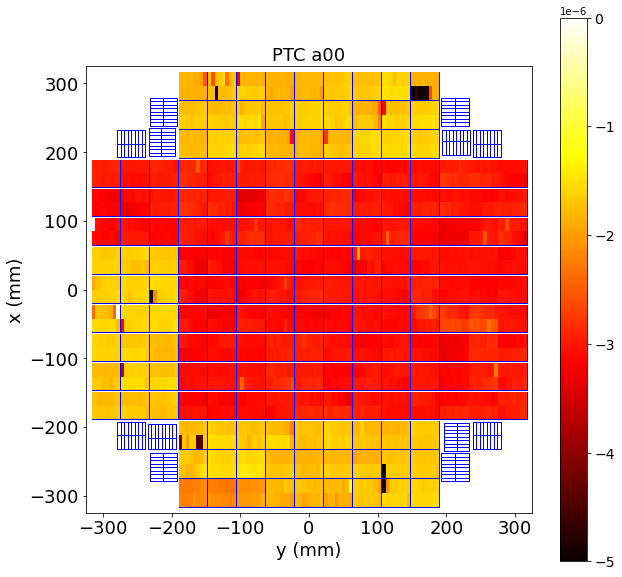

In [8]:
fig, axes = plt.subplots(figsize=(10,10))
axes.set_aspect('equal')
z2 = get_median_nsigma_range(a00_values, nsigma=3, use_log10=False)
plot_focal_plane(axes, a00_values, camera=camera, z_range=(-5e-6,0), title='PTC a00');
fig.savefig('./FocalPlane_plots/Focal_plane_a00.png', dpi=500, bbox_inches='tight')

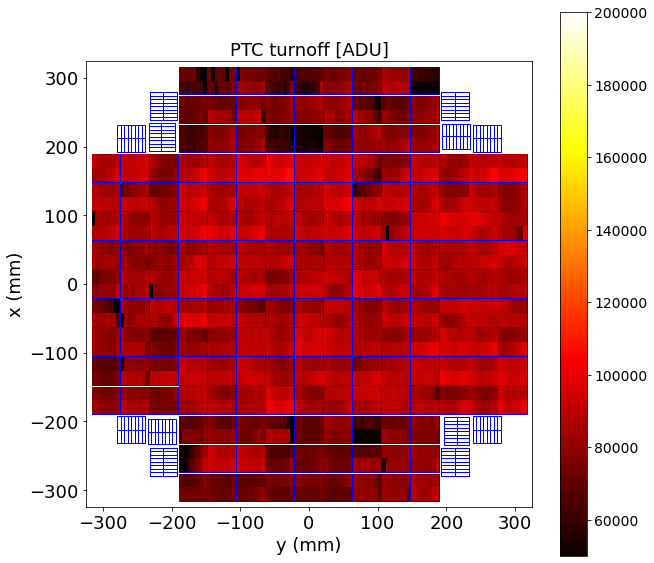

In [15]:
fig, axes = plt.subplots(figsize=(10,10))
axes.set_aspect('equal')
z3 = get_median_nsigma_range(turnoff_values, nsigma=4, use_log10=False)
plot_focal_plane(axes, turnoff_values, camera=camera, z_range=(50000,200000), title='PTC turnoff [ADU]');
fig.savefig('./FocalPlane_plots/Focal_plane_turnoff.png', dpi=500, bbox_inches='tight')

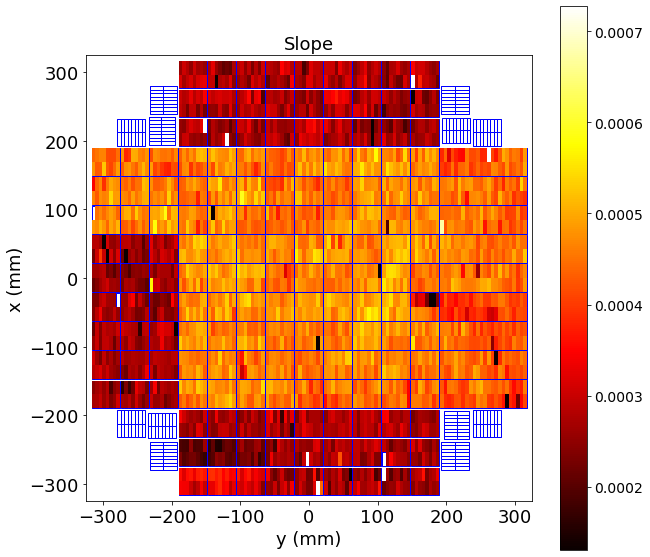

In [21]:
fig, axes = plt.subplots(figsize=(10,10))
axes.set_aspect('equal')
z4 = get_median_nsigma_range(clean_slope, nsigma=3, use_log10=False)
plot_focal_plane(axes, clean_slope, camera=camera, z_range=z4, title='Slope');
fig.savefig('./FocalPlane_plots/Focal_plane_slope.png', dpi=500)

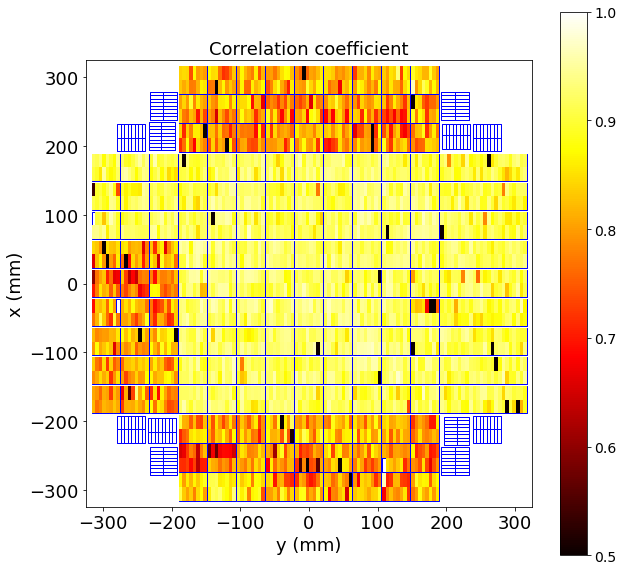

In [22]:
fig, axes = plt.subplots(figsize=(10,10))
axes.set_aspect('equal')
z5 = get_median_nsigma_range(clean_corr_coef, nsigma=3, use_log10=False)
plot_focal_plane(axes, clean_corr_coef, camera=camera, z_range=(0.5,1), title='Correlation coefficient');
fig.savefig('./FocalPlane_plots/Focal_plane_corr_coef.png', dpi=500)

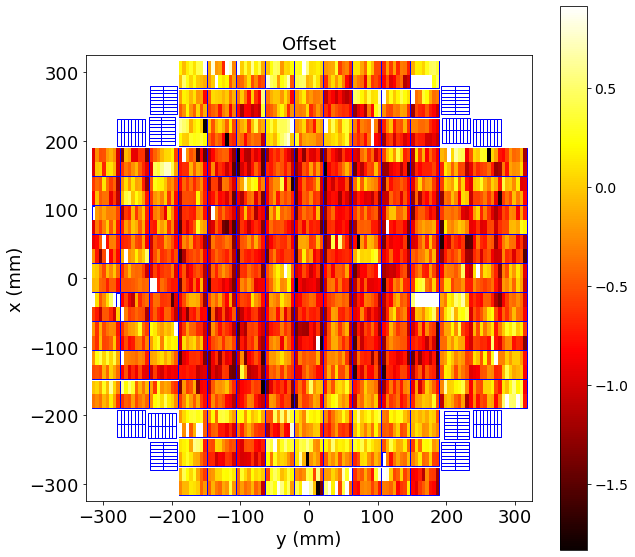

In [23]:
fig, axes = plt.subplots(figsize=(10,10))
axes.set_aspect('equal')
z6 = get_median_nsigma_range(clean_offset, nsigma=3, use_log10=False)
plot_focal_plane(axes, clean_offset, camera=camera, z_range=z6, title='Offset');
fig.savefig('./FocalPlane_plots/Focal_plane_offset.png', dpi=500)

In [12]:
z5

(0.5748448499651642, 1.224113342430797)

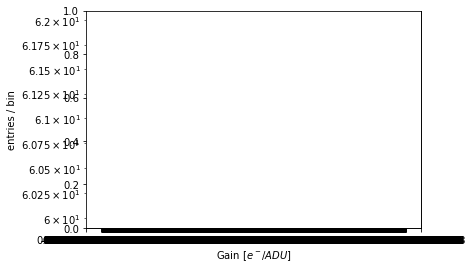

In [44]:
hist_amp_data(offset, 'Gain [$e^-/ADU$]', color='crimson', bins=50,
                 yscale='log', use_log10=False)

In [14]:
corr_values = []
for _ in corr_coef.values():
    corr_values.extend(_.values())


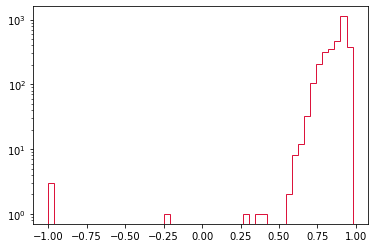

In [15]:
plt.hist(corr_values, bins=50, histtype='step',
             color='crimson', label='Correlation coefficient')
plt.yscale('log')
plt.show()